# Постановка задачи
Для самостоятельного знакомстав с некоторыми техниками представленными в курсе поработаем с простым набором данных с Kaggle.com. Данные представляют собой 50 тысяч отзывов на фильмы с сайта IMDB, размеченные на положительные и отрицательные (https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 
Попробуем решить простую задачу классификации. В качетсве метрики будем ориентироваться на макроусредненную F1-меру.

# Загрузка данных, анализ, предобработка

Загрузим бибилиотеки, сделаем импорты

In [ ]:
!pip install --upgrade matplotlib > None
!pip install --upgrade scikit-learn > None
!pip install bs4 > None
!pip install clean-text > None
!pip install unicode > None
!pip install spacy > None
!pip install nltk > None


import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from bs4 import BeautifulSoup
from cleantext import clean
from textblob import TextBlob
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk
from wordcloud import WordCloud

Загрузим данные и посмотрим на них.

In [ ]:
path = 'IMDB Dataset.csv'
data = pd.read_csv(path)
df = data.copy()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Видим некоторое количество html разметки, есть проблемы с пунктуацией. Мы это, конечно, почистим, но попозже

Проверим данные на наличие повторений и удалим дубли

In [ ]:
df.duplicated().sum()

418

In [ ]:
df = df.drop_duplicates()
df.shape

(49582, 2)

Сделаем разметку классов

In [ ]:
df['target'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df.head()

,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


Немного почистим текст. (Наверное не лучшая функция очистки, но хотелось немного потрогать разные модули)

In [ ]:
def text_cleaner(text):
  soup = BeautifulSoup(text, 'html.parser')
  text = soup.get_text()
  fix_spaces = re.compile(r'\s*([?!.,]+(?:\s+[?!.,]+)*)\s*')
  text = fix_spaces.sub(lambda x: "{} ".format(x.group(1).replace(" ", "")), text)
  text = re.sub(r"can't", "cannot", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub(r"-", " ", text)
  text = re.sub(r"  ", " ", text)
  text = re.sub(r"(\'[a-zA-Z]+)", "", text)
  text = text.strip(' ')
  text = clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=True,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="",
    replace_with_email="",
    replace_with_phone_number="",
    replace_with_number="",
    replace_with_digit="",
    replace_with_currency_symbol=""
  )
  return text


df['cleaned review'] = df['review'].apply(
  lambda x: text_cleaner(x)
)
df.head()

,review,sentiment,target,cleaned review
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,basically there a family where a little boy ja...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei love in the time of money is a v...


На первый взгляд, почистили неплохо.
Проверим сбалансированность классов, построим пару графиков 

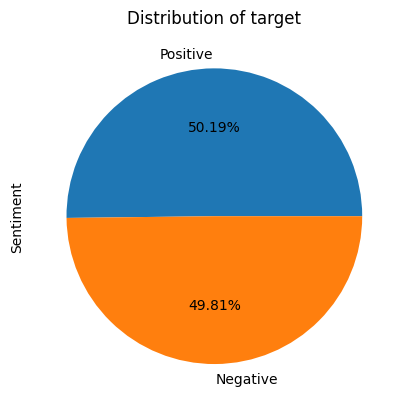

In [ ]:
plt.pie(df['sentiment'].value_counts(), labels=['Positive','Negative'], autopct='%.2f%%');
plt.title('Distribution of target')
plt.ylabel('Sentiment');

Классы сбалансированы.

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


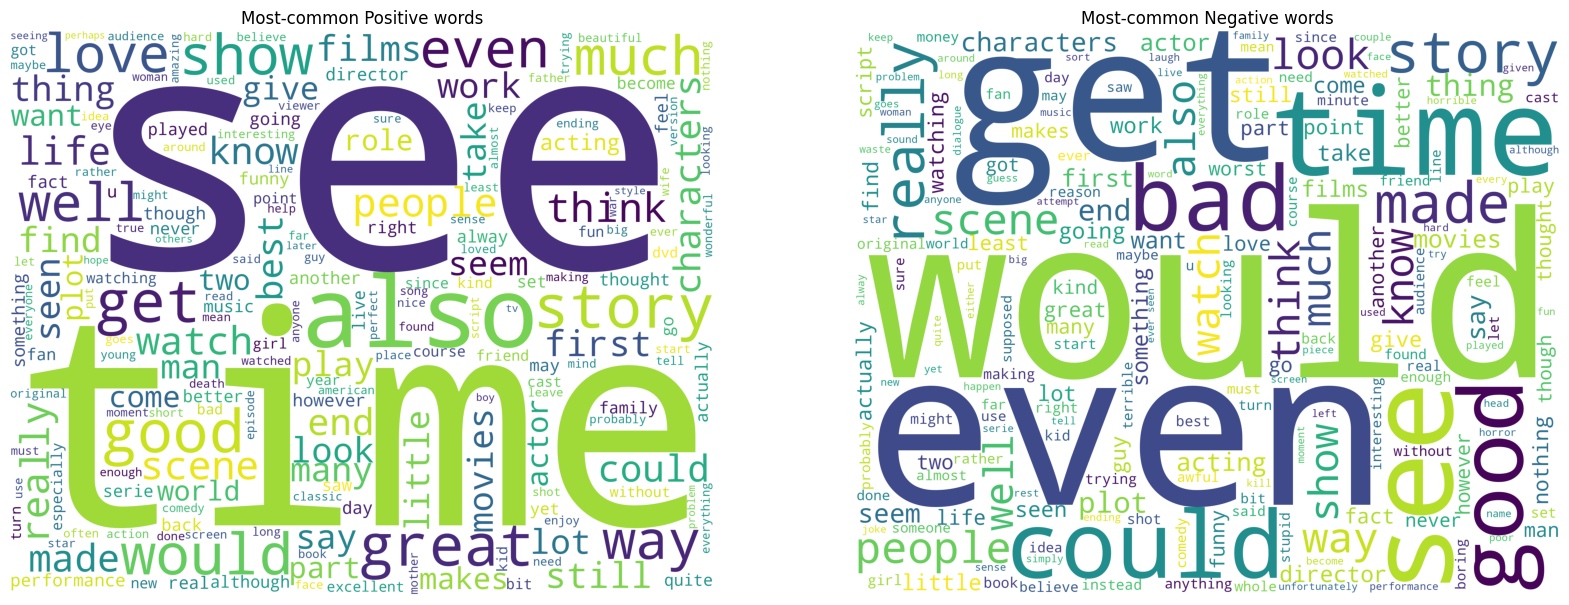

In [ ]:
positivedata = df[df['sentiment']== 'positive']
positivedata =positivedata['cleaned review']
negdata = df[df['sentiment']== 'negative']
negdata= negdata['cleaned review']
stop_list = stopwords.words('english')
stop_list_film = ['movie', 'film', 'character', 'one', 'like', 'make']
full_stop_list = stop_list + stop_list_film
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    words = ' '.join([word for word in words.split()])
    wordcloud = WordCloud(stopwords = full_stop_list, background_color=color, width=2500, height=2000).generate(words)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Most-common Positive words')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','Most-common Negative words')
plt.show()

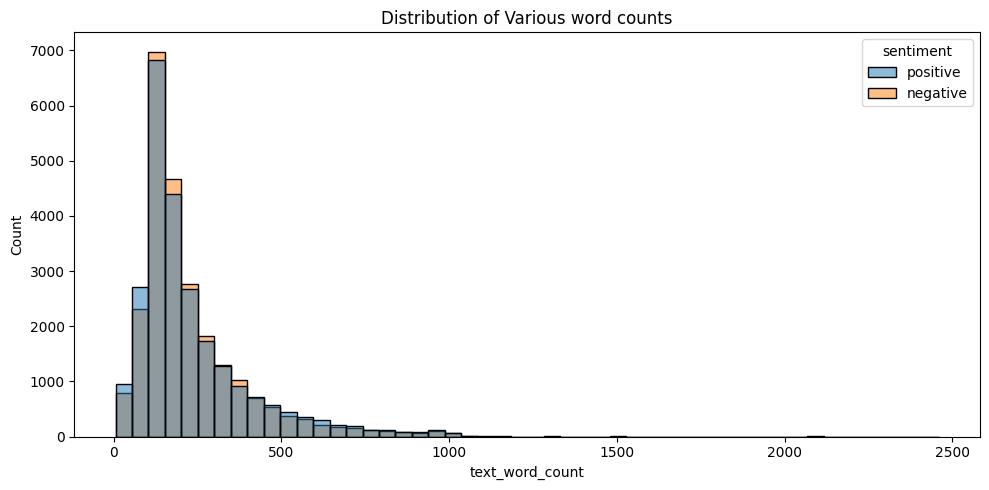

In [ ]:
df['text_word_count']=df['cleaned review'].apply(lambda x:len(x.split()))
numerical_feature_cols=['text_word_count']
plt.figure(figsize=(10,5))
for i, col in enumerate(numerical_feature_cols):
    sns.histplot(data=df, x=col, hue='sentiment', bins=50)
    plt.title(f"Distribution of Various word counts")
plt.tight_layout()
plt.show()


# Построим бейзлайн модель
Тут выберем логистическую регрессию с tfidf векторизатором.

Попробуем:
1. обучить модель на сырых данных
2. обучить модель на очищенных данных

Модель на сырых данных:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['target'], test_size = 0.5, random_state = 123)
pipe = Pipeline(
    steps = [
        ('tdidf', TfidfVectorizer(max_df = 0.6, min_df = 0.01)),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12406
           1       0.87      0.89      0.88     12385

    accuracy                           0.88     24791
   macro avg       0.88      0.88      0.88     24791
weighted avg       0.88      0.88      0.88     24791



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned review'], df['target'], test_size = 0.5, random_state = 123)
pipe_1 = Pipeline(
    steps = [
        ('tdidf', TfidfVectorizer(max_df =  0.6, min_df = 0.01)),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe_1.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12406
           1       0.87      0.89      0.88     12385

    accuracy                           0.88     24791
   macro avg       0.88      0.88      0.88     24791
weighted avg       0.88      0.88      0.88     24791



Модели показывают сравнимое качество. Судя по всему, набор данных достаточно хороший, чтобы способы обработки, встроенные в векторизатор с ним справлялись.

# Подбор гиперпараметров

In [ ]:
pipe_1 = Pipeline(
    steps = [
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
)
parameter_grid = {
    "tfidf__max_df": [0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
    "tfidf__min_df": [0.001, 0.003, 0.005, 0.007, 0.1],
    "tfidf__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10)
}

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
grid_search = HalvingGridSearchCV(
    pipe_1,
    param_grid = parameter_grid,
    n_jobs=-1,
    verbose=1,
    scoring='f1_macro',
    random_state = 123,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 34
max_resources_: 24791
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1200
n_resources: 34
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
----------
iter: 1
n_candidates: 400
n_resources: 102
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 2
n_candidates: 134
n_resources: 306
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 3
n_candidates: 45
n_resources: 918
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 4
n_candidates: 15
n_resources: 2754
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 5
n_candidates: 5
n_resources: 8262
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 6
n_candidates: 2
n_resources: 24786
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(error_score='raise',
                    estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'tfidf__max_df': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                  0.95],
                                'tfidf__min_df': [0.001, 0.003, 0.005, 0.007,
                                                  0.1],
                                'tfidf__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=123, scoring='f1_macro', verbose=1)

In [ ]:
estimator = grid_search.best_estimator_
preds = estimator.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     12406
           1       0.88      0.90      0.89     12385

    accuracy                           0.89     24791
   macro avg       0.89      0.89      0.89     24791
weighted avg       0.89      0.89      0.89     24791



# Интерпретация

In [25]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())
!pip install eli5
import eli5

UTF-8
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=7e30b2ff06334d700ff6d0f6365b3ba826a0a6fd86f9e8af790967932ee96858
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [27]:
eli5.show_weights(
    estimator = grid_search.best_estimator_['clf'],
    feature_names=list(grid_search.best_estimator_['tfidf'].get_feature_names_out()),
    top = (25, 25)
)

Weight?,Feature
+6.996,great
+5.953,excellent
+4.983,perfect
+4.689,best
+4.156,today
+4.142,amazing
+4.010,fun
+3.969,loved
+3.913,wonderful
+3.700,brilliant


В целом, модель неплохо рапознала слова, имеющие позитивную или негативную окраску.
Во втором задании посмотрим, сможем ли мы улучшить бейзлайн:)